# Practica 3

José Delgado, Javier Ortí, Joan Benlloch

1. Estructura de los datos\
*Carpeta images*: Contiene las imágenes originales de los problemas gastrointestinales, que son las entradas (X) del modelo. Estas imágenes tienen características que el modelo necesita aprender para identificar áreas relevantes.\
*Carpeta masks*: Contiene las máscaras de segmentación correspondientes, que son las salidas deseadas (y). Cada máscara tiene el mismo tamaño que su imagen correspondiente y está compuesta por valores binarios (0 y 1):\
0: Representa los píxeles de fondo (no relacionados con el área de interés).\
1: Representa los píxeles que pertenecen a la región de interés (por ejemplo, pólipos o anomalías).\
El modelo se entrena para generar máscaras similares a las de la carpeta masks al procesar imágenes de la carpeta images.

### 1. Preparar el Dataset

transformamos las imágenes y las máscaras en un formato que el modelo pueda procesar:

Carga de imágenes y máscaras: Se leen los archivos .jpg de ambas carpetas, asegurando que cada máscara esté correctamente alineada con su imagen correspondiente.\
Redimensionamiento: Todas las imágenes y máscaras se redimensionan a un tamaño fijo (256x256 en este caso) para que puedan pasar por el modelo. Esto es necesario porque los modelos de deep learning requieren tamaños uniformes.\
Normalización:\
Las imágenes se normalizan dividiendo los valores de los píxeles por 255 (para que estén en el rango [0, 1]).\
Las máscaras permanecen en valores binarios (0 o 1) para representar correctamente las áreas de segmentación.

In [17]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

IMG_HEIGHT, IMG_WIDTH = 256, 256

def is_image_file(filename):
    valid_extensions = ['.jpg', '.jpeg', '.png']
    return any(filename.lower().endswith(ext) for ext in valid_extensions)

def load_data(image_dir, mask_dir):
    images, masks = [], []
    for img_name in os.listdir(image_dir):
        if not is_image_file(img_name):
            continue  # Skip non-image files
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, img_name)
        try:
            image = img_to_array(load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))) / 255.0
            mask = img_to_array(load_img(mask_path, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="grayscale")) / 255.0
            images.append(image)
            masks.append(mask)
        except Exception as e:
            print(f"Failed to process {img_name}: {e}")
    return np.array(images), np.array(masks)

image_dir = 'images'
mask_dir = 'masks'
images, masks = load_data(image_dir, mask_dir)

X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)


In [2]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((800, 256, 256, 3),
 (800, 256, 256, 1),
 (200, 256, 256, 3),
 (200, 256, 256, 1))

### 2. Transfer Learning de ResNet50 para hacer un Autoencoder

3. Entrenamiento del modelo\
El proceso de entrenamiento consiste en mostrar al modelo imágenes de entrada (X) y sus máscaras correspondientes (y), de manera que pueda aprender la relación entre ambas.

Entrada (X): Imagen original (por ejemplo, una imagen de una colonoscopia).\
Salida esperada (y): Máscara correspondiente, donde los píxeles que representan pólipos están marcados con 1.\
En cada iteración:

La imagen pasa por la red convolucional (DeepLab o el modelo definido) que genera una máscara predicha (y_pred) de dimensiones (256x256x1).\
El modelo compara la máscara predicha (y_pred) con la máscara real (y) utilizando la función de pérdida (en este caso, binary cross-entropy).\
Los gradientes calculados por la pérdida ajustan los pesos del modelo para mejorar futuras predicciones.

4. Cómo aprende el modelo\
Durante el entrenamiento:

El modelo extrae características de las imágenes usando capas convolucionales.\
Por ejemplo, identifica patrones relacionados con bordes, texturas y colores que son típicos de las áreas de interés (como los pólipos).\
Las capas de upsampling (deconvoluciones) reconstruyen la máscara a partir de estas características aprendidas, pixel a pixel.\
El modelo ajusta sus pesos para minimizar la diferencia entre la máscara generada (y_pred) y la máscara real (y).

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Model

def build_deeplab_model_fixed(input_size=(IMG_HEIGHT, IMG_WIDTH, 3)):
    # Cargar el modelo base (ResNet50)
    base_model = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_shape=input_size)
    base_model.trainable = False

    # Extraer la última capa del modelo base
    x = base_model.output  # Salida típica: (None, 8, 8, 2048)

    # Upsampling para restaurar el tamaño original
    x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)  # De 8x8 a 16x16
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)  # De 16x16 a 32x32
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)  # De 32x32 a 64x64
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D(size=(4, 4), interpolation='bilinear')(x)  # De 64x64 a 256x256
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    # Salida final con un canal (máscara binaria)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)

    return Model(inputs=base_model.input, outputs=outputs)

model = build_deeplab_model_fixed()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()



2024-12-15 20:36:00.760277: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-15 20:36:00.762003: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (AMD Radeon RX 6800)
2024-12-15 20:36:01.532100: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 1 (Intel(R) UHD Graphics 770)
2024-12-15 20:36:01.566446: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-15 20:36:01.566462: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [9]:
output_shape = model.output_shape
print(f"Output shape of the model: {output_shape}")  # Debería ser (None, 256, 256, 1)


Output shape of the model: (None, 256, 256, 1)


### 3. Entrenar el Modelo

He parado el entrenamiento en la epoch 36

In [10]:
batch_size = 16
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=batch_size
)

Epoch 1/5


2024-12-15 19:21:30.682046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.3949 - accuracy: 0.8235

2024-12-15 19:21:37.890224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-15 19:21:38.097476: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-15 19:21:38.097536: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-15 19:21:38.097603: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 29205 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-12-15 19:21:38.097632: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

50/50 [==============================] - 9s 124ms/step - loss: 0.3949 - accuracy: 0.8235 - val_loss: 0.3523 - val_accuracy: 0.8523
Epoch 2/5
50/50 [==============================] - 6s 115ms/step - loss: 0.3645 - accuracy: 0.8368 - val_loss: 0.3474 - val_accuracy: 0.8529
Epoch 3/5
50/50 [==============================] - 6s 113ms/step - loss: 0.3614 - accuracy: 0.8395 - val_loss: 0.3565 - val_accuracy: 0.8396
Epoch 4/5
50/50 [==============================] - 6s 112ms/step - loss: 0.3598 - accuracy: 0.8391 - val_loss: 0.3459 - val_accuracy: 0.8529
Epoch 5/5
50/50 [==============================] - 6s 112ms/step - loss: 0.3648 - accuracy: 0.8384 - val_loss: 0.3521 - val_accuracy: 0.8546


### 4. Fine-tuning

In [14]:
input_size=(IMG_HEIGHT, IMG_WIDTH, 3)
# Descongelar las últimas capas del modelo base
base_model = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_shape=input_size)
base_model.trainable = True
fine_tune_at = 100  # Número de capas a descongelar

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])




In [15]:
#hago una copia del modelo para hacer el fuine tuning
model_fine_tuned = model

In [16]:
history_fine = model_fine_tuned.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=batch_size
)

Epoch 1/20
50/50 [==============================] - 80s 2s/step - loss: 0.3220 - accuracy: 0.8541 - val_loss: 0.3333 - val_accuracy: 0.8437
Epoch 2/20
50/50 [==============================] - 80s 2s/step - loss: 0.3201 - accuracy: 0.8548 - val_loss: 0.3317 - val_accuracy: 0.8443
Epoch 3/20
50/50 [==============================] - 80s 2s/step - loss: 0.3192 - accuracy: 0.8558 - val_loss: 0.3343 - val_accuracy: 0.8430
Epoch 4/20
50/50 [==============================] - 81s 2s/step - loss: 0.3182 - accuracy: 0.8558 - val_loss: 0.3341 - val_accuracy: 0.8437
Epoch 5/20
50/50 [==============================] - 80s 2s/step - loss: 0.3180 - accuracy: 0.8564 - val_loss: 0.3405 - val_accuracy: 0.8427
Epoch 6/20
50/50 [==============================] - 80s 2s/step - loss: 0.3172 - accuracy: 0.8571 - val_loss: 0.3342 - val_accuracy: 0.8439
Epoch 7/20
50/50 [==============================] - 81s 2s/step - loss: 0.3180 - accuracy: 0.8563 - val_loss: 0.3312 - val_accuracy: 0.8449
Epoch 8/20
50/50 [==

### 5. Evaluar y Guardar el Modelo

In [12]:
loss, acc = model.evaluate(X_val, y_val, batch_size=8)
print(f"Validation Loss: {loss}, Validation Accuracy: {acc}")

model.save('deeplabv3_segmentation.h5')


25/25 [==============================] - 1s 45ms/step - loss: 0.3370 - accuracy: 0.8412
Validation Loss: 0.3369520902633667, Validation Accuracy: 0.8412032127380371


In [17]:
# Evaluación del modelo fine-tuned
loss, acc = model_fine_tuned.evaluate(X_val, y_val, batch_size=8)
print(f"Validation Loss: {loss}, Validation Accuracy: {acc}")

model_fine_tuned.save('deeplabv3_segmentation_finetuned.h5')


25/25 [==============================] - 1s 44ms/step - loss: 0.3298 - accuracy: 0.8449
Validation Loss: 0.3297668397426605, Validation Accuracy: 0.8449129462242126


### Modelos más recientes

Probemos con un EfficientNet más moderno sin usar el B7, puesto que este requiere de datasets más grandes si no queremos llegar a hacer overfiting.
Además base_model.trainable = False (El transfer learning) puede que no sea la mejor opción. Quizás sea interesante entrenar la base del modelo.

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Model

def build_deeplab_model_fixed(input_size=(IMG_HEIGHT, IMG_WIDTH, 3)):
    base_model = tf.keras.applications.EfficientNetB3(include_top=False, input_shape=input_size, weights='imagenet')
    base_model.trainable = False  # Mantener congelado durante el entrenamiento inicial

    x = base_model.output

    # Aumentar el upsampling para igualar la salida a las dimensiones de entrada
    x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)  # Esto depende de cuánto reduce la dimensión el modelo base
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)  # Añadido un upsampling adicional
    x = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

    return Model(inputs=base_model.input, outputs=x)

model = build_deeplab_model_fixed()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_6 (Rescaling)        (None, 256, 256, 3)  0           ['input_5[0][0]']                
                                                                                                  
 normalization_3 (Normalization  (None, 256, 256, 3)  7          ['rescaling_6[0][0]']            
 )                                                                                                
                                                                                            

In [9]:

# Entrenamiento inicial solo en las capas superiores
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

# # Descongelar algunas o todas las capas del modelo base y continuar el entrenamiento
# for layer in model.layers[:len(model.layers)-3]:  # Ejemplo: descongela todas excepto las últimas tres
#     layer.trainable = True

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Tasa de aprendizaje más baja para el fine-tuning
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# # Continuar entrenamiento con fine-tuning
# model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))


Epoch 1/10


2024-12-15 21:07:17.635539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - ETA: 0s - loss: 0.4237 - accuracy: 0.8392

2024-12-15 21:07:24.213798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-15 21:07:24.595072: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-15 21:07:24.595112: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-15 21:07:24.595154: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 29205 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-12-15 21:07:24.595170: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

25/25 [==============================] - 10s 297ms/step - loss: 0.4237 - accuracy: 0.8392 - val_loss: 0.3621 - val_accuracy: 0.8529
Epoch 2/10
25/25 [==============================] - 6s 252ms/step - loss: 0.3750 - accuracy: 0.8395 - val_loss: 0.3544 - val_accuracy: 0.8529
Epoch 3/10
25/25 [==============================] - 6s 255ms/step - loss: 0.3730 - accuracy: 0.8395 - val_loss: 0.3560 - val_accuracy: 0.8529
Epoch 4/10
25/25 [==============================] - 6s 254ms/step - loss: 0.3677 - accuracy: 0.8395 - val_loss: 0.3523 - val_accuracy: 0.8529
Epoch 5/10
25/25 [==============================] - 6s 253ms/step - loss: 0.3659 - accuracy: 0.8395 - val_loss: 0.3596 - val_accuracy: 0.8529
Epoch 6/10
25/25 [==============================] - 6s 251ms/step - loss: 0.3723 - accuracy: 0.8395 - val_loss: 0.3571 - val_accuracy: 0.8529
Epoch 7/10
25/25 [==============================] - 6s 252ms/step - loss: 0.3660 - accuracy: 0.8395 - val_loss: 0.3527 - val_accuracy: 0.8529
Epoch 8/10
25/25

In [36]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, concatenate, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import UpSampling2D

def create_model(input_shape):
    base_model = EfficientNetB4(include_top=False, weights='imagenet', input_shape=input_shape)

    # Outputs from selected layers for feature concatenation
    layer_names = ['block2a_expand_activation', 'block3a_expand_activation', 'block4a_expand_activation', 'block6a_expand_activation']
    layers = [base_model.get_layer(name).output for name in layer_names]

    x = base_model.output  # This should be small, typically 1/32 of input size

    # Start Decoder
    x = UpSampling2D((2, 2), interpolation='bilinear')(x)  # up to 16x16
    x = concatenate([x, layers[3]])  # Skip connection from block6a
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D((2, 2), interpolation='bilinear')(x)  # up to 32x32
    x = concatenate([x, layers[2]])  # Skip connection from block4a
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D((2, 2), interpolation='bilinear')(x)  # up to 64x64
    x = concatenate([x, layers[1]])  # Skip connection from block3a
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D((2, 2), interpolation='bilinear')(x)  # up to 128x128
    x = concatenate([x, layers[0]])  # Skip connection from block2a
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D((2, 2), interpolation='bilinear')(x)  # up to 256x256
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # Output layer for segmentation map
    output = Conv2D(1, (1, 1), activation='sigmoid')(x)  # Single channel output for binary mask

    model = Model(inputs=base_model.input, outputs=output)
    return model

# Recreate the model with corrected output size
model = create_model((IMG_HEIGHT, IMG_WIDTH, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Verify model summary
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_6 (Rescaling)        (None, 256, 256, 3)  0           ['input_4[0][0]']                
                                                                                                  
 normalization_3 (Normalization  (None, 256, 256, 3)  7          ['rescaling_6[0][0]']            
 )                                                                                                
                                                                                            

In [37]:
# Split data into training and validation
train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)

# Train the model
history = model.fit(train_images, train_masks, validation_data=(val_images, val_masks), epochs=10, batch_size=16)


Epoch 1/10


2024-12-15 21:46:17.004972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.4041 - accuracy: 0.8792

2024-12-15 21:46:49.470941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-15 21:46:49.958006: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-15 21:46:49.958041: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-15 21:46:49.958061: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 29205 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-12-15 21:46:49.958072: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

50/50 [==============================] - 39s 515ms/step - loss: 0.4041 - accuracy: 0.8792 - val_loss: 0.7810 - val_accuracy: 0.8529
Epoch 2/10
50/50 [==============================] - 24s 487ms/step - loss: 0.1494 - accuracy: 0.9378 - val_loss: 1.0975 - val_accuracy: 0.8529
Epoch 3/10
50/50 [==============================] - 24s 490ms/step - loss: 0.0978 - accuracy: 0.9576 - val_loss: 0.4954 - val_accuracy: 0.8529
Epoch 4/10
50/50 [==============================] - 24s 489ms/step - loss: 0.0714 - accuracy: 0.9670 - val_loss: 0.7846 - val_accuracy: 0.8529
Epoch 5/10
50/50 [==============================] - 24s 490ms/step - loss: 0.0669 - accuracy: 0.9690 - val_loss: 0.5201 - val_accuracy: 0.7339
Epoch 6/10
50/50 [==============================] - 24s 488ms/step - loss: 0.0603 - accuracy: 0.9710 - val_loss: 0.4598 - val_accuracy: 0.8336
Epoch 7/10
50/50 [==============================] - 24s 491ms/step - loss: 0.0583 - accuracy: 0.9719 - val_loss: 0.4948 - val_accuracy: 0.8550
Epoch 8/10

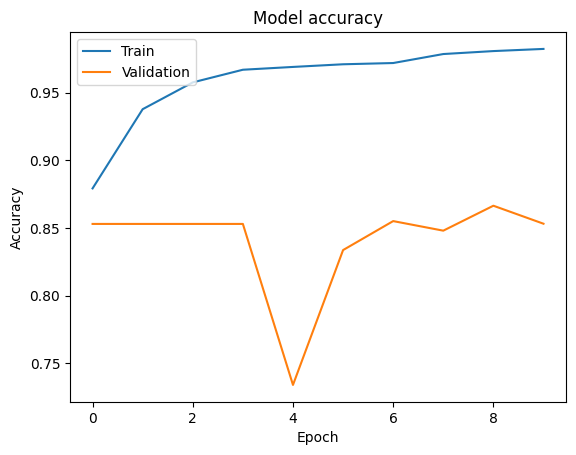

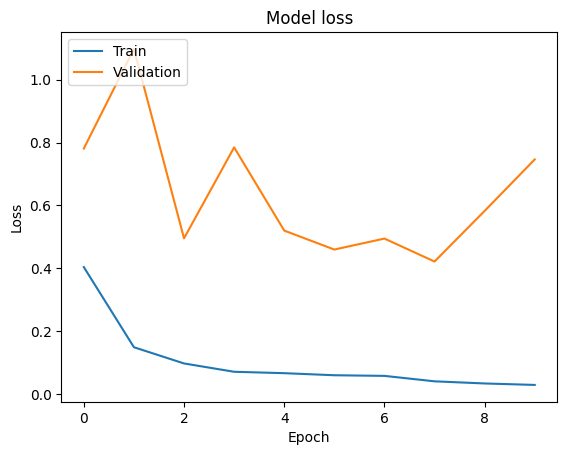

In [38]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
